In [0]:
import argparse
import os

import gym
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
from time import time
import keras as K

import imageio

In [0]:
env_name = None
initial_timestamp = 0.0
np.random.seed(1024)

In [0]:
class DQNetwork:

    def __init__(self, state_size, action_size, action_high=1.0, action_low=0.0, layer_sizes=(64, 64),
                 batch_norm_options=(True, True), dropout_options=(0, 0), learning_rate=0.0001):
        self.state_size = state_size
        self.action_size = action_size
        self.action_high = action_high
        self.action_low = action_low
        self.layer_sizes = layer_sizes
        self.batch_norm_options = batch_norm_options
        self.dropout_options = dropout_options
        self.learning_rate = learning_rate

        self.build_model()

    def build_model(self):
        states = K.layers.Input(shape=(self.state_size,), name='states')
        net = states
        # hidden layers

        for layer_count in range(len(self.layer_sizes)):
            net = K.layers.Dense(units=self.layer_sizes[layer_count])(net)
            net = K.layers.Activation('relu')(net)
            if self.batch_norm_options[layer_count]:
                net = K.layers.BatchNormalization()(net)
            net = K.layers.Dropout(self.dropout_options[layer_count])(net)

        actions = K.layers.Dense(units=self.action_size, activation='linear',
                                 name='raw_actions')(net)

        self.model = K.models.Model(inputs=states, outputs=actions)

        self.optimizer = K.optimizers.Adam(lr=self.learning_rate)
        self.model.compile(loss='mse', optimizer=self.optimizer)

In [0]:

import random
from collections import namedtuple, deque
class DDQNAgent:

    def __init__(self, env, buffer_size=int(1e5), batch_size=64, gamma=0.99, tau=1e-3, lr=5e-4, callbacks=()):
        self.env = env
        self.env.seed(1024)
        self.batch_size = batch_size
        self.gamma = gamma
        self.tau = tau
        self.Q_targets = 0.0
        self.state_size = env.observation_space.shape[0]
        self.action_size = env.action_space.n
        self.callbacks = callbacks

        layer_sizes = [256, 256]
        batch_norm_options = [False, False]
        dropout_options = [0, 0]

        print("Initialising DDQN Agent with params : {}".format(self.__dict__))

        # Make local & target model
        print("Initialising Local DQNetwork")
        self.local_network = DQNetwork(self.state_size, self.action_size,
                                       layer_sizes=layer_sizes,
                                       batch_norm_options=batch_norm_options,
                                       dropout_options=dropout_options,
                                       learning_rate=lr)

        print("Initialising Target DQNetwork")
        self.target_network = DQNetwork(self.state_size, self.action_size,
                                        layer_sizes=layer_sizes,
                                        batch_norm_options=batch_norm_options,
                                        dropout_options=dropout_options,
                                        learning_rate=lr)

        self.memory = ReplayBuffer(buffer_size=buffer_size, batch_size=batch_size)

    def reset_episode(self):
        state = self.env.reset()
        self.last_state = state
        return state

    def step(self, action, reward, next_state, done):
        self.memory.add(self.last_state, action, reward, next_state, done)

        if len(self.memory) > self.batch_size:
            experiences = self.memory.sample()
            self.learn(experiences, self.gamma)

        self.last_state = next_state

    def act(self, state, eps=0.):
        state = np.reshape(state, [-1, self.state_size])
        action = self.local_network.model.predict(state)

        if random.random() > eps:
            return np.argmax(action)
        else:
            return random.choice(np.arange(self.action_size))

    def learn(self, experiences, gamma):
        states, actions, rewards, next_states, dones = experiences

        for itr in range(len(states)):
            state, action, reward, next_state, done = states[itr], actions[itr], rewards[itr], next_states[itr], dones[
                itr]
            state = np.reshape(state, [-1, self.state_size])
            next_state = np.reshape(next_state, [-1, self.state_size])

            self.Q_targets = self.local_network.model.predict(state)
            if done:
                self.Q_targets[0][action] = reward
            else:
                next_Q_target = self.target_network.model.predict(next_state)[0]
                self.Q_targets[0][action] = (reward + gamma * np.max(next_Q_target))

            self.local_network.model.fit(state, self.Q_targets, epochs=1, verbose=0, callbacks=self.callbacks)

    def update_target_model(self):
        self.target_network.model.set_weights(self.local_network.model.get_weights())


class ReplayBuffer:

    def __init__(self, buffer_size, batch_size):
        self.memory = deque(maxlen=buffer_size)  # internal memory (deque)
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])

    def add(self, state, action, reward, next_state, done):
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)

    def sample(self):
        experiences = random.sample(self.memory, k=self.batch_size)

        states = np.vstack([e.state for e in experiences if e is not None])
        actions = np.vstack([e.action for e in experiences if e is not None])
        rewards = np.vstack([e.reward for e in experiences if e is not None])
        next_states = np.vstack([e.next_state for e in experiences if e is not None])
        dones = np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)

        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        return len(self.memory)


In [0]:
import gym
import numpy as np
import matplotlib.pyplot as plt
from IPython import display as ipythondisplay
from pyvirtualdisplay import Display

def train_model(n_episodes=2000, eps_start=1.0, eps_end=0.001, eps_decay=0.9, target_reward=1000):
    scores = []
    scores_window = deque(maxlen=100)
    eps = eps_start
    print("Starting model training for {} episodes.".format(n_episodes))
    consolidation_counter = 0
    for i_episode in range(1, n_episodes + 1):
        init_time = time()
        state = agent.reset_episode()
        score = 0
        done = False
        while not done:
            action = agent.act(state, eps)
            next_state, reward, done, _ = env.step(action)
            agent.step(action, reward, next_state, done)
            state = next_state
            score += reward
            if done:
                agent.update_target_model()
                break
        time_taken = time() - init_time
        scores_window.append(score)
        scores.append(score)
        eps = max(eps_end, eps_decay * eps)
        print('Episode {}\tAverage Score: {:.2f}\tScore: {:.2f}\tState: {}\tMean Q-Target: {:.4f}'
                     '\tEffective Epsilon: {:.3f}\tTime Taken: {:.2f} sec'.format(
            i_episode, np.mean(scores_window), score, state[0], np.mean(agent.Q_targets), eps, time_taken))
        if i_episode % 100 == 0:
            print(
                'Episode {}\tAverage Score: {:.2f}\tScore: {:.2f}\tState: {}\tMean Q-Target: {:.4f}\tTime Taken: {:.2f} sec '.format(
                    i_episode, np.mean(scores_window), score, state[0], np.mean(agent.Q_targets), time_taken))
            agent.local_network.model.save('save/{}_local_model_{}.h5'.format(env_name, initial_timestamp))
            agent.target_network.model.save('save/{}_target_model_{}.h5'.format(env_name, initial_timestamp))
        if np.mean(scores_window) >= target_reward:
            consolidation_counter += 1
            if consolidation_counter >= 5:
                print("Completed model training with avg reward {} over last {} episodes."
                                    " Training ran for total of {} epsiodes".format(
                    np.mean(scores_window), 100, i_episode))
                return scores
        else:
            consolidation_counter = 0
    print("Completed model training with avg reward {} over last {} episodes."
                        " Training ran for total of {} epsiodes".format(
        np.mean(scores_window), 100, n_episodes))
    return scores


def play_model(actor, env_render=False, return_render_img=False):
    state = env.reset()
    print("Start state : {}".format(state))
    score = 0
    done = False
    images = []
    R = 0
    t = 0
    while not done:
        if env_render:
            if return_render_img:
                images.append(env.render("rgb_array"))
            else:
                env.render()
        state = np.reshape(state, [-1, env.observation_space.shape[0]])
        action = actor.predict(state)
        next_state, reward, done, _ = env.step(np.argmax(action))
        R += reward
        t += 1
        state = next_state
        score += reward
        if done:
            return score, images
    return 0, images

In [0]:
def display_frames_as_gif(frames):
    """
    Displays a list of frames as a gif, with controls
    """
    plt.figure(figsize=(frames[0].shape[1] / 72.0, frames[0].shape[0] / 72.0), dpi = 72)
    patch = plt.imshow(frames[0])
    plt.axis('off')

    def animate(i):
        patch.set_data(frames[i])

    anim = animation.FuncAnimation(plt.gcf(), animate, frames = len(frames), interval=50)
    display(display_animation(anim, default_mode='loop'))

/usr/local/lib/python3.6/dist-packages/gym/envs/registration.py:14: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)


WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
Initialising DDQN Agent with params : {'env': <TimeLimit<MountainCarEnv<MountainCar-v0>>>, 'batch_size': 64, 'gamma': 0.99, 'tau': 0.001, 'Q_targets': 0.0, 'state_size': 2, 'action_size': 3, 'callbacks': []}
Initialising Local DQNetwork
Initialising Target DQNetwork
Starting model training for 2000 episodes.
Episode 1	Average Score: -200.00	Score: -200.00	State: -0.568784323526774	Mean Q-Target: -0.9939	Effective Epsilon: 0.900	Time Taken: 31.85 sec
Episode 2	Average Score: -200.00	Score: -200.00	State: -0.33969030790774896	Mean Q-Target: -1.8737	Effective Epsilon: 0.810	Time Taken: 43.42 sec
Episode 3	Average Score: -200.00	Score: -200.00	State: -0.4905505028787425	Mean Q-Target: -2.8572	Effective Epsilon: 0.729	Time Taken: 42.49 sec
Episode 4	Average Score: -200.00	Score: -200.00	State: -0.49461738610513317	Mean Q-Target: -3.8951	Effective Epsilon: 0.656	Time Taken: 42.49 sec
Episode 5	

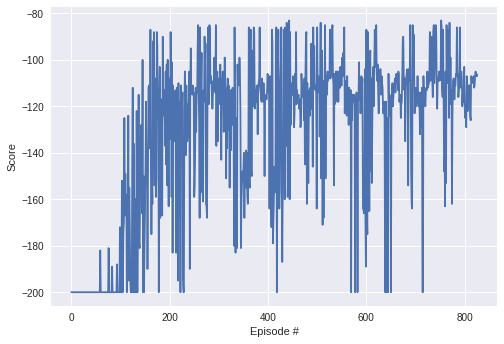

In [61]:
#train
env_name = "MountainCar-v0"
env = gym.make(env_name)1
agent = DDQNAgent(env, buffer_size=100000, gamma=0.99, batch_size=64, lr=0.0001, callbacks=[])
scores = train_model(n_episodes=2000, target_reward=-110, eps_decay=0.9)
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

In [101]:
model = "save/MountainCar-v0_local_model_0.0.h5"
total_iterations = 100
expected_reward = -110

#Test
test_scores = []
print("Loading the saved model from '{}'".format(model))
actor = K.models.load_model('{}'.format(model))
print("Now running model test for {} iterations with expected reward >= {}".format(
    total_iterations, expected_reward))
frames = play_model(actor, True, True)[1]
for itr in range(1, total_iterations + 1):
    score = play_model(actor, True)[0]
    test_scores.append(score)
    print("Iteration: {} Score: {}".format(itr, score))
avg_reward = np.mean(test_scores)
print("Total Avg. Score over {} consecutive iterations : {}".format(total_iterations,
                                                                                 avg_reward))
if avg_reward >= expected_reward:
    print("Env. solved successfully.")
else:
    print("Agent failed to solve the env.")

Loading the saved model from 'save/MountainCar-v0_local_model_0.0.h5'
Now running model test for 100 iterations with expected reward >= -110
Start state : [-0.4700453  0.       ]
Start state : [-0.49232197  0.        ]
Iteration: 1 Score: -110.0
Start state : [-0.49382264  0.        ]
Iteration: 2 Score: -110.0
Start state : [-0.44492939  0.        ]
Iteration: 3 Score: -107.0
Start state : [-0.51128727  0.        ]
Iteration: 4 Score: -111.0
Start state : [-0.47613957  0.        ]
Iteration: 5 Score: -109.0
Start state : [-0.42891906  0.        ]
Iteration: 6 Score: -106.0
Start state : [-0.47206809  0.        ]
Iteration: 7 Score: -109.0
Start state : [-0.43090693  0.        ]
Iteration: 8 Score: -106.0
Start state : [-0.58814622  0.        ]
Iteration: 9 Score: -121.0
Start state : [-0.49663564  0.        ]
Iteration: 10 Score: -110.0
Start state : [-0.54935308  0.        ]
Iteration: 11 Score: -112.0
Start state : [-0.59086348  0.        ]
Iteration: 12 Score: -121.0
Start state : 

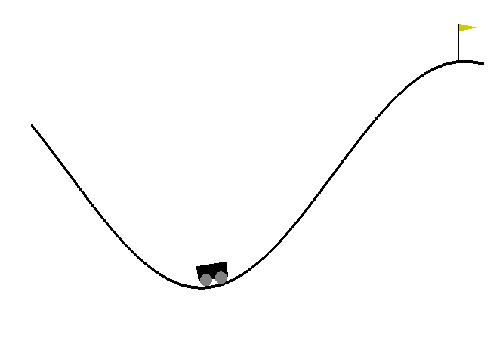

In [133]:
import matplotlib.pyplot as plt
import matplotlib.animation
import numpy as np
from IPython.display import HTML

plt.figure(figsize=(frames[0].shape[1] / 72.0, frames[0].shape[0] / 72.0), dpi = 72)
patch = plt.imshow(frames[0])
plt.axis('off')
animate = lambda i: patch.set_data(frames[i])
ani = matplotlib.animation.FuncAnimation(plt.gcf(), animate, frames=len(frames), interval = 50)
HTML(ani.to_jshtml())

In [135]:
ani.save('gifs/animation.html')

/usr/local/lib/python3.6/dist-packages/matplotlib/animation.py:1218: UserWarning: MovieWriter ffmpeg unavailable
  warnings.warn("MovieWriter %s unavailable" % writer)


In [168]:
i=0
for i in range(110):
  a = str(i).zfill(7)
  filename = "frame" + a + ".png"
  uploaded = drive.CreateFile({'title': filename})
  uploaded.SetContentFile("gifs/animation_frames/" + filename)
  uploaded.Upload()
  print("uploaded 1")

uploaded 1
uploaded 1
uploaded 1
uploaded 1
uploaded 1
uploaded 1
uploaded 1
uploaded 1
uploaded 1
uploaded 1
uploaded 1
uploaded 1
uploaded 1
uploaded 1
uploaded 1
uploaded 1
uploaded 1
uploaded 1
uploaded 1
uploaded 1
uploaded 1
uploaded 1
uploaded 1
uploaded 1
uploaded 1
uploaded 1
uploaded 1
uploaded 1
uploaded 1
uploaded 1
uploaded 1
uploaded 1
uploaded 1
uploaded 1
uploaded 1
uploaded 1
uploaded 1
uploaded 1
uploaded 1
uploaded 1
uploaded 1
uploaded 1
uploaded 1
uploaded 1
uploaded 1
uploaded 1
uploaded 1
uploaded 1
uploaded 1
uploaded 1
uploaded 1
uploaded 1
uploaded 1
uploaded 1
uploaded 1
uploaded 1
uploaded 1
uploaded 1
uploaded 1
uploaded 1
uploaded 1
uploaded 1
uploaded 1
uploaded 1
uploaded 1
uploaded 1
uploaded 1
uploaded 1
uploaded 1
uploaded 1
uploaded 1
uploaded 1
uploaded 1
uploaded 1
uploaded 1
uploaded 1
uploaded 1
uploaded 1
uploaded 1
uploaded 1
uploaded 1
uploaded 1
uploaded 1
uploaded 1
uploaded 1
uploaded 1
uploaded 1
uploaded 1
uploaded 1
uploaded 1
uploaded 1

ApiRequestError: ignored

In [152]:
ls gifs/animation_frames

frame0000000.png  frame0000028.png  frame0000056.png  frame0000084.png
frame0000001.png  frame0000029.png  frame0000057.png  frame0000085.png
frame0000002.png  frame0000030.png  frame0000058.png  frame0000086.png
frame0000003.png  frame0000031.png  frame0000059.png  frame0000087.png
frame0000004.png  frame0000032.png  frame0000060.png  frame0000088.png
frame0000005.png  frame0000033.png  frame0000061.png  frame0000089.png
frame0000006.png  frame0000034.png  frame0000062.png  frame0000090.png
frame0000007.png  frame0000035.png  frame0000063.png  frame0000091.png
frame0000008.png  frame0000036.png  frame0000064.png  frame0000092.png
frame0000009.png  frame0000037.png  frame0000065.png  frame0000093.png
frame0000010.png  frame0000038.png  frame0000066.png  frame0000094.png
frame0000011.png  frame0000039.png  frame0000067.png  frame0000095.png
frame0000012.png  frame0000040.png  frame0000068.png  frame0000096.png
frame0000013.png  frame0000041.png  frame0000069.png  frame0000097.png
frame0